In [5]:
import numpy as np
import pandas as pd
import requests
from lxml import html
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import time
import pickle
import seaborn as sns
import statsmodels.api as sm

In [11]:
def get_web_content(addr, ret = 'html'):
    try:
        pageContent = requests.get(addr) 
    except:
        print('Webpage inaccessible, please correct webpage address')
        
    if ret == 'html':
        return html.fromstring(pageContent.content)
    elif ret == 'soup':
        return BeautifulSoup(pageContent.text, 'html.parser')
    elif ret == 'htmlsoup':
        return (html.fromstring(pageContent.content),BeautifulSoup(pageContent.text, 'html.parser'))
    else:
        print('Error: ret tag is invalid in get_web_content')
        return None

        
def get_table_row(tree, xpath, counter):
    try:
        return tree.xpath(xpath.format(counter))
    except:
        print('Cannot extract table rows, check Xpath path and/or row index where content starts (int(counter))')
    

def get_cleaned_row(html_text):
    
    cleaned_html_text=[]
    
    for i in range(len(html_text)-1):
        if html_text[i] != '\n' and html_text[i+1] != '\n':
            j = 1
            while html_text[i+j] != '\n':
                html_text[i] = html_text[i] + html_text[i+j]
                html_text[i+j] = '\n'
                j += 1

    for elem in html_text:
        if elem != '\n':
            cleaned_html_text.append(elem.replace('\n',''))
    
    return cleaned_html_text[0:7]
    

def get_wiki_table_list(addr, xpath, counter, assembled_list = None):

    tree = get_web_content(addr,'html')
    html_text = get_table_row(tree, xpath, counter)
    
    if not assembled_list:
        assembled_list = []
    
    while html_text:
        assembled_list.append(get_cleaned_row(html_text))
        counter += 1
        html_text = get_table_row(tree, xpath, counter)
        
    return assembled_list  

def get_wiki_table_df(full_list,
                     columns=['Titles','Genres','Developers','Publishers','ReleaseDate_JP','ReleaseDate_EU','ReleaseDate_NA']):
    try:
        ps4_game_list = pd.DataFrame(full_list, columns = columns)
    except:
        print('Error: issues with converting scraped wiki table data into DataFrame.')
        return None
    
    release_list = [columns[4],columns[5],columns[6]]

    for col in release_list:
        try:
            ps4_game_list[col]=pd.to_datetime(ps4_game_list[col],infer_datetime_format=True,errors='coerce')
        except:
            print('Could not convert scraped release date columns into datetime format.')

    punc_dict={ord('\''):None, ord(':'):None, ord('#'):None, ord('/'):' ', 
           ord('&'):None, ord(';'):' ', ord('!'):None, ord(','):None, ord('?'):None, ord('.'):None}        
    
    ps4_game_list['TitlesHTML'] = ps4_game_list['Titles'].str.replace('\.0',' 0').str.replace('\.1',' 1').str.replace('\.5',' 5').str.replace(' -',' ').str.replace('//',' ').str.translate(punc_dict).str.replace('  ',' ').str.strip().str.lower().str.replace(' ','+')
    return ps4_game_list


In [ ]:
from IPython.core.debugger import set_trace

def find_pricing_script(script_tag):
    find = False
    counter = -1
    while not find:
        counter += 1
        try:
            script_text = script_tag[counter].text
        except:
            print('Could not find script with the price history, check web address.')
            
        if 'Price, USD' in script_text:
            find = True
            
    return script_text

def find_reg(reg_str,content):
    reg_find = re.findall(reg_str,content)
    assert reg_find is not None, "Could not extract any content, check regex string"
    return reg_find

    
def get_reg_output(soup, reg_string):
    script_text = find_pricing_script(soup.find_all('script'))
    script_text_cut = script_text[0:script_text.find('PS+')]
    return find_reg(reg_string, script_text_cut)  

def convert_date_to_cumdays(series):
    newseries = series.copy()
    newseries[0] = 0
    newseries.iloc[1:] = series.diff().iloc[1:].cumsum().dt.days
    return newseries.astype(float)

def convert_normlogprice(series):
    return np.log(series.div(series[0]))
    
def convert_price_todataframe(reg_output):
    try:
        price_history = pd.DataFrame(reg_output, columns = ['Date','Price'])
    except:
        print('Could not convert scraped price history to dataframe. Check regex function.')
    try:
        price_history['Date'] = pd.to_datetime(price_history['Date'],infer_datetime_format=True,errors='coerce')
    except:
        print('Could not convert scraped price history dates into datetime format')
    try:
        price_history['Price'] = pd.to_numeric(price_history['Price'],errors='coerce')
    except:
        print('Could not convert scraped prices into float format.')
    
    price_history['NormLogPrice'] = convert_normlogprice(price_history['Price'])
    price_history['Days'] = convert_date_to_cumdays(price_history['Date'])
    return price_history

def get_review(tree, 
               xpath_adr ='/html/body/div[1]/div[2]/div[3]/div[1]/div[1]/div/div/div/div/a/text()'):
    try:
        return float(tree.xpath(xpath_adr)[0])
    except:
        return np.nan

def get_price_historyandrev_psprices(addr, game_name = None, 
                               reg_string = r'\"x\"\:\s\"(\d{4}-\d{2}-\d{2})\"\,\s\"y\"\:\s(\d+\.\d+)'):
    
    (tree, soup) = get_web_content(addr,'htmlsoup')
    pusd = 'Price, USD' in soup.text
    sres = 'search results' in soup.text
    nfnd = 'Sorry, nothing found' in soup.text
    
    if pusd:
        reg_output = get_reg_output(soup,reg_string)
        rev_val = get_review(tree)
        return (convert_price_todataframe(reg_output),True, rev_val)
    elif sres and not nfnd:
        new_addr = get_price_history_link(tree, game_name)
        if new_addr is not None:
            (tree_new, soup_new) = get_web_content(new_addr,'htmlsoup')
            reg_output = get_reg_output(soup_new,reg_string)
            rev_val = get_review(tree_new)
            return (convert_price_todataframe(reg_output),True, rev_val)
        else:
            return (None,False,np.nan)
    else:
        return (None,False,np.nan)
    
    
def get_price_history_link(tree, game_name,
                           search_hits  = '/html/body/div[1]/div[2]/div/div/a/span/span/text()',
                           search_links = '/html/body/div[1]/div[2]/div/div/a/@href', 
                           addon = 'https://psprices.com'):

    punc_dict={ord('\''):None, ord(':'):None, ord('#'):None, ord('~'):None, 
               ord('('):None, ord(')'):None, ord('—'):None, ord('/'):' ', 
           ord('&'):None, ord(';'):' ', ord('!'):None, ord(','):None, ord('?'):None, ord('.'):None}  
    
    game_name = game_name.lower().translate(punc_dict).replace('  ',' ').replace('  ',' ')
    
    game_link_dict = {key.lower().translate(punc_dict).replace('  ',' ').replace('  ',' '):value 
                      for key, value in zip(tree.xpath(search_hits),tree.xpath(search_links))}
    
    if game_name in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name]
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' standard edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' standard edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' gold edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' gold edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' deluxe edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' deluxe edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' ps4' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' ps4']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' playstation 4 edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' playstation 4 edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None      
    elif game_name+' enhanced edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' enhanced edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    elif game_name+' game of the year edition' in game_link_dict.keys():
        try:
            return addon + game_link_dict[game_name+' game of the year edition']
        except:
            print(f"Did not find {game_name} in search results. Returning None")
            return None
    else:
        return None  


def get_all_price_histsandrev(df, col_name = 'TitlesHTML', 
                              sleep_sec = 1, 
                              pshist_link = 'https://psprices.com/region-us/search/?q={}&platform=PS4&dlc=hide'):
    game_price_dict ={}
    link_obt = []
    rev_obt = [] 
    links = df[col_name].apply(lambda x: pshist_link.format(x))
    df['SearchLinks'] = links
    
    for title, link in zip(df['Titles'], links):
        (game_price_dict[title], link_tf, rev_val) = get_price_historyandrev_psprices(link,game_name=title)
        link_obt.append(link_tf)
        rev_obt.append(rev_val)
        print(f"Price history for game: {title} was found: {link_tf}")
        time.sleep(sleep_sec)
    
    df['HistScrapped'] = link_obt
    df['Reviews'] = rev_obt
    return game_price_dict


def price_pointplot(df, title, x_col = 'Days',y_col = 'Price'):
    sns.set(color_codes=True, rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    lm = sns.pointplot(x=x_col, y=y_col, data = df, height=6.27, aspect=11.7/8.27)
    lm.axes.set_ylim(0,65)
    plt.setp(lm.get_xticklabels(), rotation=90)
    plt.title(title)

def logprice_regplot(df, title,  slope, intercept, x_col = 'Days', y_col = 'NormLogPrice', ylim=(-3,1), 
                     days = None, plotreg = False):
    sns.set(color_codes=True, rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    if days is not None:
        df_lim = df[df['Days']<=days].copy()
    lm = sns.lmplot(x=x_col, y=y_col, data = df_lim,height=6.27, aspect=11.7/8.27)
    if days is not None:
        lm.axes[0,0].set_xlim(0,days)
    lm.axes[0,0].set_ylim(ylim)
    plt.title(title)
    if plotreg:
        plt.plot(df_lim['Days'],slope*df_lim['Days']+intercept,'k*')

def logprice_reg_params(df_lim, x_col = 'Days', y_col = 'NormLogPrice', days = None, reg_model = False):
    
    if days is not None:
        df = df_lim[df_lim['Days']<=days].copy()
    else:
        df = df_lim
        
    reg_X = df[x_col].values
    reg_X = sm.add_constant(reg_X)
    model = sm.OLS(df[y_col].values, reg_X).fit() 
    
    if np.inf in np.abs(model.params):
        if reg_model:
            return([np.nan,np.nan],None)
        else:
            return([np.nan,np.nan])
    
    if reg_model:
        return (model.params, model)
    else:
        return model.params

def get_prepdf_withreg(df,game_price_dict, days = None):

    df['LogRegSlope'] = np.nan
    df['LogRegIntcpt'] = np.nan
    df['InitPrice'] = np.nan

    suc_df = df[df['Reviews'].notnull()]
    slope = []
    intercept = []
    init_price = []
    for title in suc_df['Titles']:
        sl_int = logprice_reg_params(game_price_dict[title],x_col = 'Days', 
                                     y_col = 'NormLogPrice', days = days, reg_model=False)
        slope.append(sl_int[1])
        intercept.append(sl_int[0])
        init_price.append(game_price_dict[title]['Price'][0])

    df['LogRegSlope'] = pd.DataFrame(slope,index=suc_df.index,columns=['LogRegSlope'])
    df['LogRegIntcpt'] = pd.DataFrame(intercept,index=suc_df.index,columns=['LogRegIntcpt'])
    df['InitPrice'] = pd.DataFrame(init_price,index=suc_df.index,columns=['LogRegIntcpt'])
    
    convert_genres(df)
    convert_catstrength(df,'Publishers',18,3)
    convert_catstrength(df,'Developers',4,1)
    
    df['ReleaseDate_Agg'] = np.where(df['ReleaseDate_NA'].isna(),df['ReleaseDate_EU'],df['ReleaseDate_NA'])
    df['ReleaseDate_Agg'] = np.where(df['ReleaseDate_Agg'].isna(),df['ReleaseDate_JP'],df['ReleaseDate_Agg'])
    df['Release_Year'] = ps4_game_list['ReleaseDate_Agg'].dt.year
    df['Release_Month'] = ps4_game_list['ReleaseDate_Agg'].dt.month
    df['Release_Day'] = ps4_game_list['ReleaseDate_Agg'].dt.day
    
def get_successcol(df,col='LogRegSlope',threshold = -0.0001):   
    df['Success'] = np.where(df[col] > threshold, 0,1)
    
def convert_genres(df):
    genre_transfrm = pd.read_csv('genre.csv')
    genre = {}
    for row_label,  row_array_Series   in genre_transfrm.iterrows():
        genre[row_array_Series['Old']] = row_array_Series['New']

    df['MappedGenres'] = df['Genres'].map(genre)
    try:
        assert df['MappedGenres'].notna().all()
    except:
        print("WARNING: The Genre CSV needs to be updated")

def convert_catstrength(df,col_name,med_val,low_val):
    val_cts = df[col_name].value_counts()
    val_dict = {}
    
    for name in val_cts[val_cts > med_val].index:
        val_dict[name] = 'High'+ col_name
        
    for name in val_cts[(val_cts <= med_val) & (val_cts > low_val)].index:
        val_dict[name] = 'Med'+ col_name

    for name in val_cts[val_cts <= low_val].index:
        val_dict[name] = 'Low'+ col_name
    
    new_col_name = 'Mapped{}'.format(col_name)
    
    df[new_col_name] = df[col_name].map(val_dict)
        

In [69]:
xpath_0_m = '/html/body/div[3]/div[3]/div[4]/div/table[2]//tr[{}]//text()'
html_add_0_m = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games'

xpath_m_z = '/html/body/div[3]/div[3]/div[4]/div/table/tbody/tr[{}]//text()'
html_add_m_z = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games_(M-Z)'

ps4_game_list = get_wiki_table_df(    
    get_wiki_table_list(html_add_m_z, xpath_m_z, 3, get_wiki_table_list(html_add_0_m, xpath_0_m, 3)))
    
ps4_game_pricehist_dict = {}

ps4_game_pricehist_dict = get_all_price_histsandrev(ps4_game_list)

get_prepdf_withreg(ps4_game_list, ps4_game_pricehist_dict)

get_successcol(ps4_game_list)

pickle.dump(ps4_game_pricehist_dict, open('pricehist_pkl.sav', 'wb'))

ps4_game_list.to_csv('ps4_game_list.csv')

62.0
Price history for game: #killallzombies was found: True
nan
Price history for game: 10 Second Ninja X was found: True
58.0
Price history for game: 100ft Robot Golf was found: True
65.0
Price history for game: 101 Ways to Die was found: True
77.0
Price history for game: 11-11: Memories Retold was found: True
nan
Price history for game: 13 Sentinels: Aegis Rim was found: False
75.0
Price history for game: 140 was found: True
70.0
Price history for game: 198X was found: True
79.0
Price history for game: 1001 Spikes was found: True
79.0
Price history for game: 2064: Read Only Memories was found: True
79.0
Price history for game: 20XX was found: True
66.0
Price history for game: The 25th Ward: The Silver Case was found: True
75.0
Price history for game: 2Dark was found: True
85.0
Price history for game: 428: Shibuya Scramble was found: True
38.0
Price history for game: 7 Days to Die was found: True
73.0
Price history for game: 8-bit Adventure Anthology: Volume I was found: True
nan
Pri

72.0
Price history for game: Assassin's Creed Rogue Remastered was found: True
76.0
Price history for game: Assassin's Creed Syndicate was found: True
70.0
Price history for game: Assassin's Creed Unity was found: True
82.0
Price history for game: Assault Android Cactus was found: True
71.0
Price history for game: Assault Suit Leynos was found: True
57.0
Price history for game: The Assembly was found: True
67.0
Price history for game: Assetto Corsa was found: True
nan
Price history for game: Asterix & Obelix XXL 2: Mission: Las Vegum was found: False
nan
Price history for game: Asterix & Obelix XXL 3: The Crystal Menhir was found: False
73.0
Price history for game: Astroneer was found: True
nan
Price history for game: Atari Flashback Classics: Volume 1 was found: False
nan
Price history for game: Atari Flashback Classics: Volume 2 was found: False
nan
Price history for game: Atari Flashback Classics: Volume 3 was found: False
nan
Price history for game: Atelier Ayesha: The Alchemist of

80.0
Price history for game: Bloodstained: Ritual of the Night was found: True
71.0
Price history for game: Bloody Zombies was found: True
10.0
Price history for game: Bloons TD 5 was found: True
nan
Price history for game: Blue Estate was found: False
68.0
Price history for game: Blue Reflection was found: True
nan
Price history for game: Blue Rider was found: True
nan
Price history for game: Blues and Bullets was found: False
70.0
Price history for game: Boiling Bolt was found: True
nan
Price history for game: Bokosuka Wars II was found: True
77.0
Price history for game: Bomber Crew was found: True
73.0
Price history for game: The Book of Unwritten Tales 2 was found: True
70.0
Price history for game: Borderlands 3 was found: True
73.0
Price history for game: Borderlands: Game of the Year Edition was found: True
83.0
Price history for game: Borderlands: The Handsome Collection was found: True
72.0
Price history for game: Bound was found: True
nan
Price history for game: Boundary was f

nan
Price history for game: Constructor HD was found: True
nan
Price history for game: Constructor Plus was found: True
76.0
Price history for game: Contra Anniversary Collection was found: True
nan
Price history for game: Contra: Rogue Corps was found: True
59.0
Price history for game: Contrast was found: True
nan
Price history for game: Control was found: True
nan
Price history for game: Convallaria was found: False
76.0
Price history for game: Cook, Serve, Delicious! 2 was found: True
nan
Price history for game: Cook, Serve, Delicious! 3 was found: False
79.0
Price history for game: Cosmic Star Heroine was found: True
71.0
Price history for game: Costume Quest 2 was found: True
nan
Price history for game: Cotton Reboot was found: False
75.0
Price history for game: The Count Lucanor was found: True
68.0
Price history for game: CounterSpy was found: True
79.0
Price history for game: Crash Bandicoot N. Sane Trilogy was found: True
nan
Price history for game: Crash Team Racing Nitro-Fue

nan
Price history for game: Digimon Survive was found: False
69.0
Price history for game: Digimon World: Next Order was found: True
83.0
Price history for game: Dirt 4 was found: True
nan
Price history for game: Dirt Rally was found: False
nan
Price history for game: Dirt Rally 2.0 was found: False
nan
Price history for game: Disaster Report 4 Plus: Summer Memories was found: False
69.0
Price history for game: Disc Jam was found: True
nan
Price history for game: Disco Elysium was found: False
79.0
Price history for game: Disgaea 1 Complete was found: True
nan
Price history for game: Disgaea 4 Complete+ was found: True
84.0
Price history for game: Disgaea 5 Complete was found: True
77.0
Price history for game: Dishonored: Definitive Edition was found: True
85.0
Price history for game: Dishonored 2 was found: True
81.0
Price history for game: Dishonored: Death of the Outsider was found: True
nan
Price history for game: Disintegration was found: True
78.0
Price history for game: The Disne

nan
Price history for game: ESP Ra.De. Psy was found: False
77.0
Price history for game: Ether One was found: True
70.0
Price history for game: Etherborn was found: True
nan
Price history for game: Euro Fishing was found: True
80.0
Price history for game: Eve: Valkyrie - Warzone was found: True
73.0
Price history for game: Eventide: Slavic Fable was found: True
75.0
Price history for game: Eventide 2: Sorcerer's Mirror was found: True
70.0
Price history for game: Eventide 3: Legacy of Legends was found: True
nan
Price history for game: Everspace was found: False
nan
Price history for game: Everspace 2 was found: False
78.0
Price history for game: Everybody's Golf was found: True
78.0
Price history for game: Everybody's Gone to the Rapture was found: True
74.0
Price history for game: Everything was found: True
72.0
Price history for game: The Evil Within was found: True
79.0
Price history for game: The Evil Within 2 was found: True
nan
Price history for game: Evolve was found: False
nan

60.0
Price history for game: Gal*Gun 2 was found: True
nan
Price history for game: Gal Gunvolt was found: True
nan
Price history for game: Game Dev Story was found: False
nan
Price history for game: Game of Thrones was found: False
67.0
Price history for game: Gang Beasts was found: True
80.0
Price history for game: The Gardens Between was found: True
nan
Price history for game: Garfield Kart: Furious Racing was found: True
85.0
Price history for game: Garou: Mark of the Wolves was found: True
nan
Price history for game: Gas Guzzlers Extreme was found: True
nan
Price history for game: Gauntlet: Slayer Edition was found: True
60.0
Price history for game: Gemini: Heroes Reborn was found: True
nan
Price history for game: Gem Smashers was found: True
51.0
Price history for game: Generation Zero was found: True
nan
Price history for game: Genshin Impact was found: False
nan
Price history for game: Gensō No Rondo was found: False
83.0
Price history for game: Geometry Wars 3: Dimensions was f

nan
Price history for game: Horizon Zero Dawn was found: True
nan
Price history for game: Hotline Miami was found: True
73.0
Price history for game: Hotline Miami 2: Wrong Number was found: True
nan
Price history for game: Hot Springs Story was found: False
nan
Price history for game: The House in Fata Morgana: Dream of the Revenants Edition was found: False
67.0
Price history for game: How to Survive: Storm Warning Edition was found: True
65.0
Price history for game: How to Survive 2 was found: True
80.0
Price history for game: Hue was found: True
67.0
Price history for game: Human: Fall Flat was found: True
nan
Price history for game: Humanity was found: False
nan
Price history for game: Hunt: Showdown was found: False
54.0
Price history for game: The Huntsman: Winter's Curse was found: True
73.0
Price history for game: Hyper Jam was found: True
83.0
Price history for game: Hyper Light Drifter was found: True
nan
Price history for game: Hyper Void was found: True
57.0
Price history f

nan
Price history for game: Kingdom Hearts HD 1.5 + 2.5 Remix was found: False
nan
Price history for game: Kingdom Hearts HD 2.8 Final Chapter Prologue was found: False
nan
Price history for game: Kingdom Hearts: The Story So Far was found: False
nan
Price history for game: Kingdom Hearts III was found: True
72.0
Price history for game: Kingdom: New Lands was found: True
79.0
Price history for game: Kingdom: Two Crowns was found: True
nan
Price history for game: King's Quest was found: False
nan
Price history for game: Kitty Powers' Matchmaker was found: True
nan
Price history for game: Klaus was found: False
57.0
Price history for game: Knack was found: True
72.0
Price history for game: Knack 2 was found: True
75.0
Price history for game: Knights and Bikes was found: True
nan
Price history for game: A Knight's Quest was found: True
nan
Price history for game: Knock Knock was found: False
70.0
Price history for game: Knot was found: True
70.0
Price history for game: Knowledge is Power 

82.0
Price history for game: Lovers in a Dangerous Spacetime was found: True
83.0
Price history for game: Lumines Remastered was found: True
75.0
Price history for game: Lumo was found: True
nan
Price history for game: Luna was found: True
nan
Price history for game: Machinarium was found: True
68.0
Price history for game: Mad Max was found: True
nan
Price history for game: Madden NFL 15 was found: False
83.0
Price history for game: Madden NFL 16 was found: True
82.0
Price history for game: Madden NFL 17 was found: True
nan
Price history for game: Madden NFL 18 was found: True
79.0
Price history for game: Madden NFL 19 was found: True
nan
Price history for game: Madden NFL 20 was found: True
nan
Price history for game: Madden NFL 25 was found: False
nan
Price history for game: Mad Games Tycoon was found: True
nan
Price history for game: Mafia III was found: True
76.0
Price history for game: Mages of Mystralia was found: True
74.0
Price history for game: The Magic Circle: Gold Edition w

nan
Price history for game: Murder Detective: Jack the Ripper was found: False
60.0
Price history for game: Murdered: Soul Suspect was found: True
nan
Price history for game: Mushroom Wars 2 was found: False
69.0
Price history for game: Mutant Football League was found: True
nan
Price history for game: Mutant Mudds Deluxe was found: True
nan
Price history for game: Mutant Mudds Super Challenge was found: True
nan
Price history for game: Mutant Year Zero: Road to Eden was found: False
nan
Price history for game: Mutazione was found: True
42.0
Price history for game: MX vs. ATV Supercross Encore was found: True
nan
Price history for game: MXGP The Official Motocross Videogame was found: True
nan
Price history for game: MXGP 2 was found: False
nan
Price history for game: MXGP 3 was found: False
nan
Price history for game: MXGP 2019 was found: True
nan
Price history for game: MX Nitro was found: True
70.0
Price history for game: My Big Sister was found: True
69.0
Price history for game: My

62.0
Price history for game: One Piece: World Seeker was found: True
nan
Price history for game: One-Punch Man: A Hero Nobody Knows was found: False
nan
Price history for game: One Tap Hero was found: False
nan
Price history for game: One Upon Light was found: False
80.0
Price history for game: Onimusha: Warlords was found: True
72.0
Price history for game: Oninaki was found: True
nan
Price history for game: Onrush was found: False
62.0
Price history for game: The Order: 1886 was found: True
nan
Price history for game: Organ Trail was found: False
nan
Price history for game: Organic Panic was found: True
nan
Price history for game: The Oriental Exorcist was found: False
46.0
Price history for game: Our World is Ended was found: True
55.0
Price history for game: Oure was found: True
nan
Price history for game: Outer Wilds was found: True
nan
Price history for game: The Outer Worlds was found: True
76.0
Price history for game: Outlast was found: True
76.0
Price history for game: Outlast 

nan
Price history for game: Psychonauts 2 was found: False
nan
Price history for game: Puddle was found: True
nan
Price history for game: Pumped BMX + was found: True
nan
Price history for game: Punch Club was found: True
67.0
Price history for game: Punch Line was found: True
nan
Price history for game: Pure Chess was found: True
nan
Price history for game: Pure Farming 2018 was found: True
nan
Price history for game: Pure Hold'em was found: True
70.0
Price history for game: Pure Pool was found: True
74.0
Price history for game: Push Me Pull You was found: True
nan
Price history for game: Putty Squad was found: True
74.0
Price history for game: Puyo Puyo Champions was found: True
83.0
Price history for game: Puyo Puyo Tetris was found: True
nan
Price history for game: Puzzle by Nikoli 4: Akari was found: False
nan
Price history for game: Puzzle by Nikoli 4: Hashiwokakero was found: False
nan
Price history for game: Puzzle by Nikoli 4: Heyawake was found: False
nan
Price history for ga

86.0
Price history for game: Rocket League was found: True
75.0
Price history for game: Rock of Ages 2: Bigger & Boulder was found: True
nan
Price history for game: Rock of Ages III: Make & Break was found: False
nan
Price history for game: Rockets Rockets Rockets was found: True
83.0
Price history for game: Rocksmith 2014 was found: True
79.0
Price history for game: Rogue Aces was found: True
nan
Price history for game: Rogue Company was found: False
84.0
Price history for game: Rogue Legacy was found: True
62.0
Price history for game: Rogue Stormers was found: True
nan
Price history for game: Rollers of the Realm was found: False
68.0
Price history for game: Romance of the Three Kingdoms XIII was found: True
nan
Price history for game: Romance of the Three Kingdoms XIV was found: False
69.0
Price history for game: Romancing SaGa 2 was found: True
nan
Price history for game: Romancing SaGa 3 was found: True
70.0
Price history for game: Ronin was found: True
nan
Price history for game:

nan
Price history for game: Skylanders: Trap Team was found: False
50.0
Price history for game: SkyScrappers was found: True
nan
Price history for game: SlabWell was found: True
62.0
Price history for game: Slain: Back from Hell was found: True
77.0
Price history for game: Slayaway Camp: Butcher's Cut was found: True
91.0
Price history for game: Slay the Spire was found: True
77.0
Price history for game: Sleeping Dogs: Definitive Edition was found: True
77.0
Price history for game: Slime Rancher was found: True
nan
Price history for game: Slime-san: Super Slime Edition was found: False
67.0
Price history for game: Small Radios Big Televisions was found: True
nan
Price history for game: SmuggleCraft was found: True
74.0
Price history for game: Snake Pass was found: True
nan
Price history for game: Sniper: Ghost Warrior 3 was found: True
nan
Price history for game: Sniper: Ghost Warrior Contracts was found: True
nan
Price history for game: Sniper Elite V2 Remastered was found: True
78.0


77.0
Price history for game: Sunless Sea: Zubmariner Edition was found: True
nan
Price history for game: Sunless Skies: Sovereign Edition was found: False
76.0
Price history for game: Superbeat: Xonic was found: True
72.0
Price history for game: Super Blood Hockey was found: True
64.0
Price history for game: Super Bomberman R was found: True
nan
Price history for game: Super Buckyball Tournament was found: False
79.0
Price history for game: Super Cane Magic Zero was found: True
77.0
Price history for game: Super Cloudbuilt was found: True
nan
Price history for game: Super Dodgeball Beats was found: True
47.0
Price history for game: Super Dungeon Bros was found: True
nan
Price history for game: Super Exploding Zoo was found: True
82.0
Price history for game: Superhot was found: True
79.0
Price history for game: Super Hydorah was found: True
nan
Price history for game: Super Impossible Road was found: False
nan
Price history for game: Superliminal was found: False
83.0
Price history for 

79.0
Price history for game: Tom Clancy's The Division was found: True
79.0
Price history for game: Tom Clancy's The Division 2 was found: True
31.0
Price history for game: Tony Hawk's Pro Skater 5 was found: True
nan
Price history for game: Tools Up! was found: True
80.0
Price history for game: Tooth and Tail was found: True
nan
Price history for game: Torchlight II was found: True
60.0
Price history for game: Toren was found: True
80.0
Price history for game: Torment: Tides of Numenera was found: True
nan
Price history for game: TorqueL was found: True
nan
Price history for game: Tottemo E Mahjong Plus was found: False
38.0
Price history for game: Touhou Kobuto V: Burst Battle was found: True
nan
Price history for game: Touhou Sōjin Engi: The Genius of Sappheiros was found: False
nan
Price history for game: Touhou Sky Arena Matsuri was found: True
76.0
Price history for game: Toukiden 2 was found: True
76.0
Price history for game: Toukiden: Kiwami was found: True
nan
Price history fo

83.0
Price history for game: VVVVVV was found: True
nan
Price history for game: The Walking Dead: Michonne was found: False
nan
Price history for game: The Walking Dead: Season One was found: False
72.0
Price history for game: The Walking Dead: Season Two was found: True
nan
Price history for game: The Walking Dead: Season Three was found: False
77.0
Price history for game: The Walking Dead: The Final Season was found: True
84.0
Price history for game: Wandersong was found: True
70.0
Price history for game: Wand Wars was found: True
82.0
Price history for game: Wargroove was found: True
nan
Price history for game: Warhammer 40,000: Deathwatch was found: False
64.0
Price history for game: Warhammer 40,000: Inquisitor – Martyr was found: True
nan
Price history for game: Warhammer 40,000: Mechanicus was found: False
nan
Price history for game: Warhammer 40,000: Space Wolf was found: False
nan
Price history for game: Warhammer: Chaosbane was found: True
77.0
Price history for game: Warhamm

nan
Price history for game: Zhanguo Pohuaishen was found: False
nan
Price history for game: Zheros was found: True
77.0
Price history for game: Ziggurat was found: True
66.0
Price history for game: Zombi was found: True
64.0
Price history for game: Zombie Army Trilogy was found: True
nan
Price history for game: Zombie Army 4: Dead War was found: True
65.0
Price history for game: Zombie Vikings was found: True
nan
Price history for game: Zone of the Enders: The 2nd Runner – Mars was found: True
55.0
Price history for game: Zotrix was found: True


PermissionError: [Errno 13] Permission denied: 'ps4_game_list.csv'

In [ ]:
#test1 = a[a['MappedPublishers'] == 'LowPublishers']
d = []
b = []
for val in np.arange(500,650,5):
    get_prepdf_withreg(a,ps4_game_pricehist_dict,val)
    test1 = a
    plt.plot(test1['Reviews'],test1['LogRegSlope'],'k.')
    
    d.append(test1[['LogRegSlope','Reviews']].corr()['Reviews'][0])
    b.append(val)
    
    #plt.ylim(-.00015,.0015)
    print(test1[['LogRegSlope','Reviews']].corr()['Reviews'][0],val)

c = np.column_stack([d,b])
c[np.where(np.max(c[:,0]) == c[:,0]),1][0][0]


get_prepdf_withreg(a,ps4_game_pricehist_dict,555)
test1 = a
test1['Simp'] = test1['LogRegSlope'].add(test1['Reviews'].mul(np.mean(test1['LogRegSlope']*-5)/max(test1['Reviews'])))-0.004
plt.plot(test1['Reviews'],test1['Simp'],'k.')



In [144]:
get_prepdf_withreg(ps4_game_list, ps4_game_pricehist_dict, days=555)
get_successcol(ps4_game_list,threshold=-0.001)
ps4_game_list['Success'].value_counts()
ps4_game_list.columns

Index(['Titles', 'Genres', 'Developers', 'Publishers', 'ReleaseDate_JP',
       'ReleaseDate_EU', 'ReleaseDate_NA', 'TitlesHTML', 'SearchLinks',
       'HistScrapped', 'Reviews', 'LogRegSlope', 'LogRegIntcpt', 'InitPrice',
       'MappedGenres', 'MappedPublishers', 'MappedDevelopers',
       'ReleaseDate_Agg', 'Release_Year', 'Release_Month', 'Release_Day',
       'Success'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1210 entries, 0 to 1213
Data columns (total 9 columns):
Reviews             1210 non-null float64
InitPrice           1210 non-null float64
MappedGenres        1210 non-null object
MappedPublishers    1210 non-null object
MappedDevelopers    1210 non-null object
Release_Year        1210 non-null float64
Release_Month       1210 non-null float64
Release_Day         1210 non-null float64
Success             1210 non-null int32
dtypes: float64(5), int32(1), object(3)
memory usage: 89.8+ KB
Index(['Reviews', 'InitPrice', 'MappedGenres', 'MappedPublishers',
       'MappedDevelopers', 'Release_Year', 'Release_Month', 'Release_Day'],
      dtype='object')


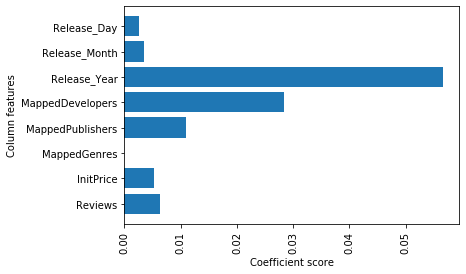


Analysis for : logreg
The best parameters for: logreg are :{'logreg__C': 0.8}
   mean_test_score              params
0         0.690083  {'logreg__C': 0.8}
1         0.690083    {'logreg__C': 1}
2         0.689050  {'logreg__C': 1.2}
3         0.690083  {'logreg__C': 1.4}
The score for logreg is 0.7148760330578512

Analysis for : knnstep
The best parameters for: knnstep are :{'knnstep__n_neighbors': 14}
    mean_test_score                        params
0          0.634298   {'knnstep__n_neighbors': 3}
1          0.664256   {'knnstep__n_neighbors': 4}
2          0.668388   {'knnstep__n_neighbors': 5}
3          0.664256   {'knnstep__n_neighbors': 6}
4          0.659091   {'knnstep__n_neighbors': 7}
5          0.664256   {'knnstep__n_neighbors': 8}
6          0.653926   {'knnstep__n_neighbors': 9}
7          0.671488  {'knnstep__n_neighbors': 10}
8          0.653926  {'knnstep__n_neighbors': 11}
9          0.664256  {'knnstep__n_neighbors': 12}
10         0.660124  {'knnstep__n_neighbor

In [171]:
df = ps4_game_list[['Reviews', 'InitPrice',
       'MappedGenres', 'MappedPublishers', 'MappedDevelopers',
                    'Release_Year', 'Release_Month', 'Release_Day',
       'Success']].copy()

sucrev_index = df[df['Reviews'].notna()].dropna().index
df = df[df['Reviews'].notna()].reset_index().drop(['index'],axis=1).dropna()

df.info()

df_all = df 

#df_all = pd.read_csv('../dat/cc_approvals_text.csv',na_values='?')
#df_all = df_all.drop(['Tweet'],axis=1)

x_train, x_test, y_train, y_test = preprocess_block(df_all, text_col=None, cat_var_limit=10, bin_rep=1,
                     max_tfidf_features=100, ngram_range=(1,2),
                     use_feat_select=True, 
                     alpha_space=np.linspace(0.01,0.02,20), 
                     random_state_var=20, test_size_var=.2)

_ = shallow_model(x_train, x_test, y_train, y_test)

_ = deep_model(x_train, x_test, y_train, y_test)

clf_shallow = load_model(clf='logreg')

clf_deep    = load_model('deep','Trained_deep_model.h5')

print(clf_shallow.predict(x_test))
print(clf_deep.predict(x_test))


In [233]:
df = ps4_game_list[['Reviews', 'InitPrice',
       'MappedGenres', 'MappedPublishers', 'MappedDevelopers',
                    'Release_Year', 'Release_Month', 'Release_Day',
       'Success']].copy()

val = clf_shallow.predict_proba(preprocess_df(df_all.drop('MappedGenres',axis=1).iloc[:,:-1], text_col=None, cat_var_limit=10, bin_rep=1))
pred_prob = np.where(val[:,0]>val[:,1],val[:,0],val[:,1])

pred = clf_shallow.predict(preprocess_df(df_all.drop('MappedGenres',axis=1).iloc[:,:-1], text_col=None, cat_var_limit=10, bin_rep=1))

sucrev_index = df[df['Reviews'].notna()].dropna().index
df = df[df['Reviews'].notna()].reset_index().drop(['index'],axis=1).dropna()

ps4_game_list['SuccessPredict'] = np.nan
ps4_game_list['SuccessPredict'] = pd.DataFrame(pred,index=sucrev_index,columns=['SuccessPredict'])

ps4_game_list['SuccessPredictProb'] = np.nan
ps4_game_list['SuccessPredictProb'] = pd.DataFrame(pred_prob,index=sucrev_index,columns=['SuccessPredictProb']).mul(100)

ps4_game_list['SuccessPredictText'] = ps4_game_list['SuccessPredict'].map({0.0:'Failure',1.0:'Success'})

ps4_game_list[['Reviews','SuccessPredict','SuccessPredictText','SuccessPredictProb']]

ps4_game_list[ps4_game_list['Reviews'].notna()].dropna().to_csv('ps4_game_list_predicted.csv')

In [236]:
pd.read_csv('ps4_game_list_predicted.csv',index_col = 0).head(2)

,Titles,Genres,Developers,Publishers,ReleaseDate_JP,ReleaseDate_EU,ReleaseDate_NA,TitlesHTML,SearchLinks,HistScrapped,...,MappedPublishers,MappedDevelopers,ReleaseDate_Agg,Release_Year,Release_Month,Release_Day,Success,SuccessPredict,SuccessPredictProb,SuccessPredictText
4,11-11: Memories Retold,Adventure,AardmanDigixArt,Bandai Namco Entertainment,2018-11-09,2018-11-09,2018-11-09,11-11+memories+retold,https://psprices.com/region-us/search/?q=11-11...,True,...,HighPublishers,LowDevelopers,2018-11-09,2018.0,11.0,9.0,1,0.0,77.492137,Failure
8,1001 Spikes,Platform,8bits Fanatics,Nicalis,2015-11-27,2015-10-07,2014-06-03,1001+spikes,https://psprices.com/region-us/search/?q=1001+...,True,...,MedPublishers,LowDevelopers,2014-06-03,2014.0,6.0,3.0,0,0.0,63.963679,Failure


In [237]:
pd.read_csv('ps4_game_list_predicted.csv',index_col = 0).tail(2)

,Titles,Genres,Developers,Publishers,ReleaseDate_JP,ReleaseDate_EU,ReleaseDate_NA,TitlesHTML,SearchLinks,HistScrapped,...,MappedPublishers,MappedDevelopers,ReleaseDate_Agg,Release_Year,Release_Month,Release_Day,Success,SuccessPredict,SuccessPredictProb,SuccessPredictText
2306,Zombie Army Trilogy,Tactical shooter,Rebellion Developments,505 Games,2015-03-06,2015-03-06,2015-03-06,zombie+army+trilogy,https://psprices.com/region-us/search/?q=zombi...,True,...,HighPublishers,HighDevelopers,2015-03-06,2015.0,3.0,6.0,1,1.0,62.475664,Success
2308,Zombie Vikings,Action,Zoink Games,Zoink Games,2015-09-02,2015-09-01,2015-09-01,zombie+vikings,https://psprices.com/region-us/search/?q=zombi...,True,...,LowPublishers,MedDevelopers,2015-09-01,2015.0,9.0,1.0,1,0.0,50.724023,Failure


In [172]:
#Figure out how to push Feature selection columns in the preprocess_df block. Right now all columns are returned but if feat_select = True, some columns are rejected. This needs to be pushed out in the preprocess return call

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def convert_cat_cols(df, cat_var_limit=10, verbose=False):                
    """
    Converts columns with a small amount of unique values that are of
    type Object into categorical variables.
    Number of unique values defined by cat_var_limit
    """
    cat_var_true = df.apply(lambda x: 
                            len(x.value_counts()) < cat_var_limit)
    object_type_true = df.apply(lambda x: 
                         x.value_counts().index.dtype == 'O')
    if cat_var_true[object_type_true].any():
        df[cat_var_true[object_type_true].index] = \
        df[cat_var_true[object_type_true].index].astype('category')
        if verbose:
            print(df[cat_var_true[object_type_true].index].describe())
    return df

def impute_most_freq(df):
    """
    Imputes the most frequent value in place of NaN's
    """
    most_freq = df.apply(lambda x: x.value_counts().index[0])
    return df.fillna(most_freq)

def convert_str_int_labels(df):
    """
    Converts columns with factors into integer representation
    """
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df = df.apply(lambda x: le.fit_transform(x))
    return df

def clean_text(text_series):
    """
    Cleans a column of Tweets. Removes all special characters, 
    websites, mentions.
    """
    from re import sub as resub
    text_series = text_series.apply(
         lambda x:resub(
                "[^A-Za-z0-9 ]+|(\w+:\/\/\S+)|htt", " ", x)
                     ).str.strip().str.lower()
    return text_series

def feat_select(df, text_mat=None, test_size_var=0.3, 
                alpha_space=np.linspace(0.01,0.02,20), 
                random_state_var=21, use_feat_select=True, plot=True):
    """
    Performs feature selection on a dataframe with a single target 
    variable and n features. Test train split is also performed and only 
    splits of selected features are returned. Feature selection performed 
    using LASSO weight shrinking.
    """
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import Lasso
    
    x_train, x_test, y_train, y_test = train_test_split(
        df.iloc[:,:-1], df.iloc[:,-1], test_size=test_size_var, 
        random_state=random_state_var, stratify=df.iloc[:,-1])

    if use_feat_select:
        param_grid = {'alpha': alpha_space}
        lasso_gcv = GridSearchCV(Lasso(normalize=False), param_grid, cv=5,
                                 n_jobs=-1, iid=True)
        lasso_coeffs = lasso_gcv.fit(x_train, y_train).best_estimator_.coef_
        if plot:
            plt.barh(y=range(len(df.columns[:-1])), width=np.abs(lasso_coeffs),
                     tick_label=df.columns[:-1].values)
            plt.ylabel('Column features')
            plt.xlabel('Coefficient score')
            plt.xticks(rotation=90)
            plt.show()
        try:
            select_feats = df.columns[:-1][np.abs(lasso_coeffs) > 0].values
        except:
            print('Lasso Coefficients all turned out to be 0')
            print(' or could not be calculated. Check your')
            print(' dataset or switch off feature selection.')
                     
        x_train = x_train.loc[:,select_feats]
        x_test = x_test.loc[:,select_feats]
    
    if text_mat is not None:
        x_train = np.concatenate((x_train.values,text_mat[x_train.index,:]), axis=1)
        x_test = np.concatenate((x_test.values,text_mat[x_test.index,:]), axis=1)
    else:
        x_train = x_train.values
        x_test = x_test.values
    
    return x_train, x_test, y_train.values, y_test.values


def preprocess_df(df_all, text_col=None, cat_var_limit=10, bin_rep=1):
    
    if text_col is not None:
        df = df_all.drop([text_col], axis=1).copy() #All columns except text
    else:
        df = df_all.copy()
    
    df = impute_most_freq(convert_cat_cols(df,cat_var_limit))
    
    if bin_rep:
        try:
            df[df.select_dtypes(include=['category']).columns] = \
            convert_str_int_labels(df.select_dtypes(include=['category'])) 
            #Transforms a category variable column into an integer variable 
            #column
        except:
            print('No columns with category variables. Change bin_rep to 0')
    else:
        df = pd.get_dummies(df,drop_first=True) 
        #Converts category variables into a multicolumn binary integer 
        #representation for each unique value
    
    assert (df.notnull().all().all()), 'NaNs present in DataFrame'
    
    return df

def preprocess_df_text(df_all, text_col=None, 
                     max_tfidf_features=100, ngram_range=(1,2)):
    
    from sklearn.feature_extraction.text import TfidfVectorizer 
    try:
        df_all[text_col] = clean_text(df_all[text_col])
    except:
        print('Cannot clean text, recheck text column')
    text_numeric_matrix = TfidfVectorizer(max_features=max_tfidf_features,
                                              ngram_range=ngram_range, 
                                              stop_words='english')\
                              .fit_transform(df_all[text_col])
    
    return text_numeric_matrix
    

def preprocess_block(df_orig, text_col=None, cat_var_limit=10, bin_rep=1,
                     max_tfidf_features=100, ngram_range=(1,2),
                     use_feat_select=True, 
                     alpha_space=np.linspace(0.01,0.02,20), 
                     random_state_var=20, test_size_var=.3):
    """
    Preprocessing block: used to preprocess and transform the data columns
    ---------------------------------------------------------------------------
    -df_all (DataFrame): DataFrame with all the data, last column should be 
    target variable
    -text_col (str): name of the text column, default is None for no text columns
    -cat_var_limit (int): greatest number of unique values in a column to qualify 
    for conversion into a category column 
    -bin_rep (int): style of integer representation for category variables, 0 for 
    binary integer representation, 1 for 0 to nclass-1 representation
    -max_tfidf_features (int): maximum number of features after vectorizing text 
    column using tfidf metric
    -ngram_range (tuple): 2 tuple consisting of start and end point of ngram
    -use_feat_select (bool): True for applying feature selection using LASSO for 
    non-text columns
    -alpha_space (array of float): testing space for alpha parameter of LASSO
    -random_state_var (int): Random seed for train-test-split
    -test_size_var (float): ratio of test versus train split 
    ---------------------------------------------------------------------------
    """
    
    df_all = df_orig.copy()
    df = preprocess_df(df_all, text_col=text_col, 
                       cat_var_limit=cat_var_limit, bin_rep=bin_rep)
    
    if text_col is not None:
        text_numeric_matrix = preprocess_df_text(df_all, text_col=text_col, 
                     max_tfidf_features=max_tfidf_features, ngram_range=ngram_range)
       
        return feat_select(df, text_numeric_matrix.toarray(), 
                           test_size_var=test_size_var, 
                           use_feat_select=use_feat_select, 
                           alpha_space=alpha_space, 
                           random_state_var=random_state_var, plot=True)
    else:
        return feat_select(df, use_feat_select=use_feat_select, 
                           test_size_var=test_size_var,
                           alpha_space=alpha_space, plot=True,
                           random_state_var=random_state_var)

    
def shallow_model(x_train, x_test, y_train, y_test, scaler_ch=0,
                  logreg_C=[0.8,1,1.2,1.4], knn_neigh=np.arange(3,16),
                  svc_c=[0.5,1,1.5,2,2.5,2.6], gb_max_depth=[2,3,4,5],
                  gb_n_est=[40,60,80,100], verbose=True, save=True,
                  model_file='Trained_shallow_models.sav'): 
    """
    This function will fit and test several shallow classfication models and 
    save them, models include:
    'logreg': Logistic Regression using the lbfgs solver
    'knnstep': K Nearest Neighbors
    'svcstep': Support Vector Classification model
    'gradbooststep': Gradient Boosted Classification Trees
    
    Scaling options include:
    MinMaxScaler between a range of -1 and 1
    Normalizer 
    StandardScaler
    
    The function will also run a 5 fold cross validated grid search for 
    hyperparameter optimization
    ---------------------------------------------------------------------------
    -x_train (DataFrame or ndarray): Training data consisting of features   
    -x_test (DataFrame or ndarray): Testing data consisting of features
    -y_train (DataFrame, Series or ndarray): Training data for predictions 
    (single class only)   
    -y_train (DataFrame, Series or ndarray): Testing data for predictions 
    (single class only)   
    -scaler_ch (int): Decides which scaler to use, 0 for MinMaxScaler, 1 for 
    Normalizer, 2 for StandarScaler
    -logreg_C (list of float): Hyperparameter space for C to be used in the 
    Log Reg Classifier
    -knn_neigh (list of int): Hyperparameter space for number of neighbors to 
    be used in the KNN Classifier
    -svc_c (list of float): Hyperparameter space for C to be used in the 
    Support Vector Classifier
    -gb_max_depth (list of int): Hyperparameter space for max depth to be used 
    in Gradient Boosted Classifier Trees
    -gb_n_est (list of int): Hyperparameter space for number of estimators to 
    be used in Gradient Boosted Classifier Trees
    -verbose (bool): Prints out details if True
    -save (bool): Switch for saving the trained models in an external data file
    -model_file (str): Filename for storing all the trained models
    ---------------------------------------------------------------------------
    """   
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import SVC
    import pickle
    
    scaler = [('Scaler', MinMaxScaler(feature_range=(-1, 1))),\
             ('Scaler', Normalizer()), ('Scaler', StandardScaler())]

    classifiers = [('logreg', LogisticRegression(solver='lbfgs', 
                                                 max_iter=1000)),\
        ('knnstep', KNeighborsClassifier()),\
        ('svcstep', SVC(gamma='scale')),\
         ('gradbooststep', GradientBoostingClassifier(subsample=.8))]

    parameters = {'logreg': {'logreg__C': logreg_C} ,\
              'knnstep': {'knnstep__n_neighbors': knn_neigh},\
              'svcstep': {'svcstep__C': svc_c},\
             'gradbooststep': {'gradbooststep__max_depth': gb_max_depth,\
                              'gradbooststep__n_estimators': \
                              gb_n_est}} 
    model_dict = {}

    for clf in classifiers:
        pipeline = Pipeline([scaler[scaler_ch], clf])
        print('\nAnalysis for : ' + clf[0])
        gcv = GridSearchCV(pipeline, param_grid=parameters[clf[0]],
                           cv=5, iid=True)
        gcv.fit(x_train, y_train)
        model_dict[clf[0]] = (gcv, gcv.score(x_test, y_test))
        if verbose:
            print('The best parameters for: ' + clf[0] + ' are :' +
                  str(gcv.best_params_))
            print(pd.DataFrame(gcv.cv_results_)
                  [['mean_test_score','params']])
        print('The score for ' + clf[0] + ' is ' + 
              str(gcv.score(x_test, y_test))) 
    
    if save:
        pickle.dump(model_dict, open(model_file, 'wb'))
    
    return model_dict


def deep_model(x_train, x_test, y_train, y_test, scaler_ch=0, 
               patience_val=2, validation_split_val=.2, epochs_val=20,
               verbose=True, save=True, model_file='Trained_deep_model.h5'):
    """
    This function will fit and test a Deep Neural Network that uses ReLu 
    and softmax activation functions. It also uses an EarlyStopper
    
    Scaling options include:
    MinMaxScaler between a range of -1 and 1
    Normalizer 
    StandardScaler
    
    ---------------------------------------------------------------------
    -x_train (DataFrame or ndarray): Training data consisting of features   
    -x_test (DataFrame or ndarray): Testing data consisting of features
    -y_train (DataFrame, Series or ndarray): Training data for predictions 
    (single class only)   
    -y_train (DataFrame, Series or ndarray): Testing data for predictions 
    (single class only)    
    -scaler_ch (int): Decides which scaler to use, 0 for MinMaxScaler, 
    1 for Normalizer, 2 for StandarScaler
    -patience_val (int): Number of epochs to monitor before exiting 
    training if no major changes in accuracy occurs
    -validation_split_val (float): ratio of split of dataset for testing 
    purposes
    -epochs_val (int): Max number of epochs to train
    -verbose (bool): Model training details will be printed out if True
    -save (bool): Switch for saving the trained models in an external data 
    file
    -model_file (str): Filename for storing the trained model. Must be H5 
    extension
    ----------------------------------------------------------------------
    """   
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping
    
    scaler_list = [('Scaler', MinMaxScaler(feature_range=(-1, 1))),\
              ('Scaler', Normalizer()),\
              ('Scaler', StandardScaler())]

    scaler = scaler_list[scaler_ch][1]
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)

    n_cols = x_train.shape[-1]

    model = Sequential()
    model.add(Dense(5, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2,activation='softmax'))

    early_stop_monitor = EarlyStopping(patience=patience_val)
    model.compile (optimizer='adam',
                   loss= 'categorical_crossentropy',
                   metrics=['accuracy'])
    train_dp_model=model.fit(x_train, pd.get_dummies(y_train).values,
                             validation_split=validation_split_val, 
                             epochs = epochs_val,
                             callbacks =[early_stop_monitor],
                             verbose=verbose)

    print('Loss metrics: ' + str(train_dp_model.history['loss'][-1]))
    
    pred_prob = model.predict(x_test)
    accuracy_dp = np.sum((pred_prob[:,1]>=0.5)==y_test) / len(y_test)
    print('DNN Testing accuracy: ' + str(accuracy_dp)) 
    
    if save:
        model.save(model_file)   
    
    return model


def load_model(type='shallow', filename='Trained_shallow_models.sav', 
               clf='logreg'):
    """
    This function is used to load a previously saved trained model. 
    The model will have been saved in an external file.
    
    ---------------------------------------------------------------------
    -type (str): 'shallow' to load a trained shallow model, 
    'deep' to load a trained deep model
    -filename (str): Name of the file with the saved model
    -clf (str): Only used for retrieving shallow models, this is the label 
    of the classifier -
    'logreg': Logistic Regression using the lbfgs solver
    'knnstep': K Nearest Neighbors
    'svcstep': Support Vector Classification model
    'gradbooststep': Gradient Boosted Classification Trees
    ---------------------------------------------------------------------
    """
    assert (type == 'shallow' or type == 'deep'), 'Wrong input for type' 
    if type == 'shallow':
        import pickle
        try:
            model_dict = pickle.load(open(filename, 'rb'))
        except:
            print('Could not load file. Check filename.')
        for label, model in model_dict.items():
            print(label + ' score is: ' + str(model[1]))
        return model_dict[clf][0]
    
    elif type == 'deep':
        from keras.models import load_model 
        try:
            model = load_model(filename)
        except:
            print('Could not load file. Check filename.')
        print('Model Summary: ')
        model.summary()
        return model